This notebook is meant to walk through the process of mosaicing images to detect transient sources in TTE data. 

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO 

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

In [2]:
triggertime = '2021-06-26T08:16:15.996Z'

In [3]:
guano = GUANO(triggertime=triggertime)
print(guano)

+--------------+---------------------+------------+---------------------+----------------+
| Trigger Type |        Trigger Time | Offset (s) | Window Duration (s) | Observation ID |
+--------------+---------------------+------------+---------------------+----------------+
|      GBM GRB | 2021-06-26 08:16:15 |         50 |                 200 |    00036799012 |
+--------------+---------------------+------------+---------------------+----------------+


In [4]:
from swifttools.swift_too import GUANO, Clock, Data

obsid = guano[0].obsid

tmp_download_dir="/Users/sjs8171/Desktop"

data = Data(obsid=obsid, bat=True, outdir=tmp_download_dir, clobber=True)
ba.datadir(tmp_download_dir)
event=ba.BatEvent(obsid, is_guano=True)




In [5]:
min_time = 1.0
max_time = 2.0

time_bins=np.arange(min_time, max_time, 0.2)*u.s

energybins=[ 15., 350]*u.keV

t0 = guano[0].triggertime.met

slew_skyviews=ba.parallel.create_event_skyview(event, timebins=time_bins, energybins=energybins, is_relative=True, T0=t0, nprocs=1)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 59391.346620 from DATE-END'. [astropy.wcs.wcs]


In [6]:
mosaic_skyview = ba.parallel.mosaic_skyview(slew_skyviews, nprocs=1)

/Users/sjs8171/opt/anaconda3/envs/bat/lib/python3.10/site-packages/astropy/units/decorators.py:313: UserWarning: No astropy World Coordinate System has been specified the sky image is assumed to be in the detector tangent plane. No conversion to Healpix or RA/Dec & galactic coordinate systems will be possible.
/Users/sjs8171/opt/anaconda3/envs/bat/lib/python3.10/site-packages/histpy/histogram.py:1235: RuntimeWarning: invalid value encountered in divide


In [7]:
mosaic_detected_sources = mosaic_skyview.detect_sources(input_dict=dict(pcodethresh=0.01, snrthresh=5, aperture="CALDB:DETECTION"))

/Users/sjs8171/opt/anaconda3/envs/bat/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide


In [8]:
ra = mosaic_detected_sources[0]['SNR_skycoord'].ra.deg
dec = mosaic_detected_sources[0]['SNR_skycoord'].dec.deg

In [9]:
object_location=SkyCoord(ra = ra * u.deg, dec= dec * u.deg)

Text(0, 0.5, 'Partial covering at GRB position')

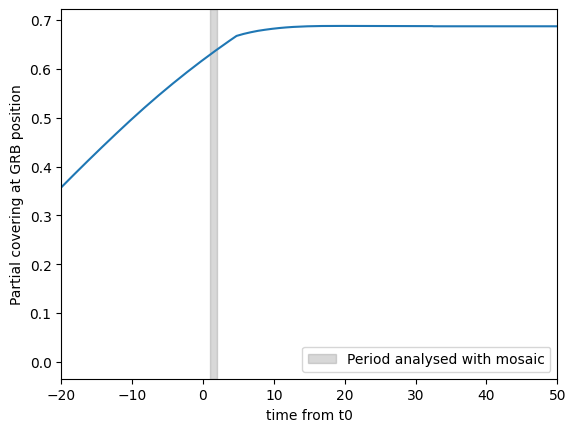

In [10]:
import swiftbat

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name='test'
)

time = event.attitude.time.value - t0*np.ones(len(event.attitude.time))

exposures = np.array(
    [object_batsource.exposure(ra=ra,
                               dec=dec, 
                               roll=roll)[0]
        for ra,dec,roll in zip(event.attitude.ra,event.attitude.dec,event.attitude.roll)
    ])

plt.plot(time,exposures/5200)
plt.xlim(-20,50)
plt.axvspan(min_time, max_time, color='gray', alpha=0.3, label="Period analysed with mosaic")
plt.legend()
plt.xlabel('time from t0')
plt.ylabel('Partial covering at GRB position')

In [11]:
event.apply_mask_weighting(ra=object_location.ra, dec=object_location.dec)

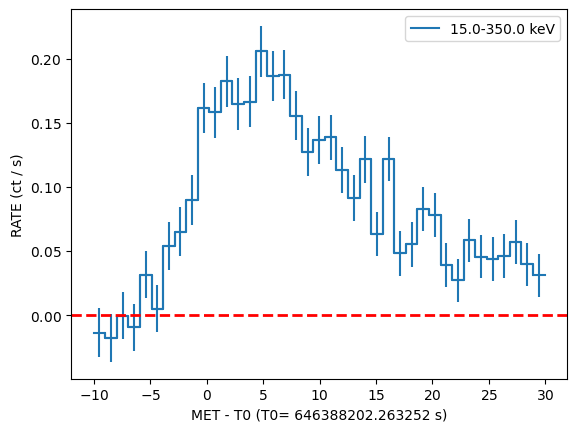

In [12]:
lc=event.create_lightcurve(energybins=[15, 350] * u.keV)
lc.set_timebins(
                timebinalg="uniform",
                timedelta=np.timedelta64(1024, 'ms'),
                tmin=-10*u.s,
                tmax=30*u.s,
                is_relative=True,
                T0=guano[0].triggertime.met)
lc.plot(T0=guano[0].triggertime.met, plot_relative=True)
plt.axhline(y=0.0, color='r', linestyle='--', linewidth=2)

In [13]:
spectrum=event.create_pha(tstart=0*u.s, tstop=10*u.s, is_relative=True, T0=guano[0].triggertime.met)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

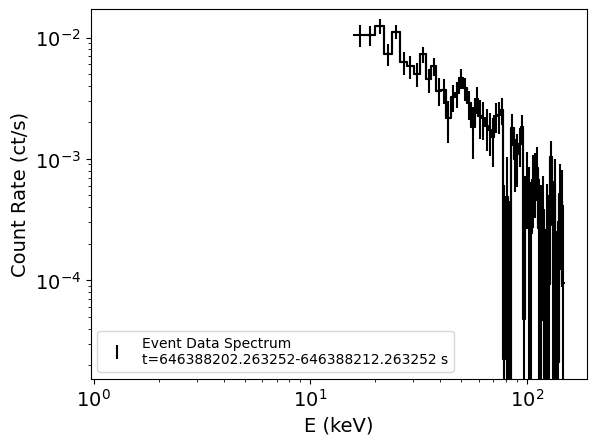

In [14]:
spectrum.plot()

In [15]:
spectrum.data

{'CHANNEL': <Quantity [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
            13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
            26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
            39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
            52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
            65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
            78., 79.]>,
 'RATE': <Quantity [ 1.76725994e-03,  5.08368062e-03,  7.39186728e-03,
             1.10758180e-02,  1.04696117e-02,  1.04317711e-02,
             1.24385683e-02,  7.37956537e-03,  1.11825564e-02,
             6.26261931e-03,  5.83445221e-03,  5.04475530e-03,
             7.28701163e-03,  4.51762896e-03,  5.77767023e-03,
             3.65517623e-03,  3.71892160e-03,  2.18083842e-03,
             3.23923647e-03,  3.46146449e-03,  4.63026258e-03,
             3.83372585e-03,  2.86527663e-03,  1.83879

In [16]:
ba.fit_spectrum(spectrum)


*** CCfits Error: For image read, starting element is out of range.

***XSPEC Error:  cannot open file named: t_646388202.263252-646388212.263252_80chan.pha


ValueError: PyCapsule_New called with null pointer